In [1]:
#Capture and save point cloud
import pyrealsense2 as rs
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from datetime import date

#Camera Setup
# Create a context object. This object owns the handles to all connected realsense devices
pipe = rs.pipeline()
# Configure streams
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color)
# Start streaming
pipe.start(config)
#Image Capture
for x in range(5):
    pipe.wait_for_frames()
frameset=pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

print("Frames Captured")
color = np.asanyarray(color_frame.get_data())
colorizer = rs.colorizer()
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

from datetime import date

today = date.today()
#Getting ply file
ply = rs.save_to_ply("clouds/"+str(today)+".ply")
ply.set_option(rs.save_to_ply.option_ply_binary, False) #?
ply.set_option(rs.save_to_ply.option_ply_normals, True) #?
ply.process(colorizer.process(frameset))

pipe.stop()



Frames Captured


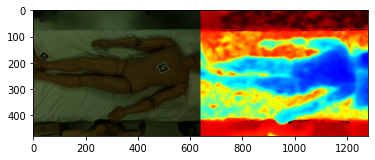

In [4]:
# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)
plt.show()

In [5]:
#Normals Vis
import open3d as o3d
from pyntcloud import PyntCloud

pcd = o3d.io.read_point_cloud("/home/sashawald/Documents/shaving_code-main/clouds/"+str(today)+".ply")

#Visualize Original
#print(pcd)
#o3d.visualization.draw_geometries([pcd])

pcd = pcd.voxel_down_sample(voxel_size=0.035)
#use draw_geometries if you don't need to edit the result
o3d.visualization.draw_geometries_with_editing([pcd])
#cloud = PyntCloud.from_instance("open3d", pcd)
#scene = cloud.plot(return_scene=True, position=(1,1,1))


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
#Code  for picking specific points: shift+left click to select, shift+right click to deselect
#close visualization window to return selected points
import numpy as np
from LineMesh import *

vis = o3d.visualization.VisualizerWithEditing()
vis.create_window()
vis.add_geometry(pcd)
vis.run()  
vis.destroy_window()
pdata = vis.get_picked_points()


[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #5334 (-0.17, -0.11, -1.4) to add in queue.
[Open3D INFO] Picked point #2092 (0.077, -0.1, -1.4) to add in queue.


In [7]:
#Visualize Cylinder Mesh + Point Cloud
points = [pcd.points[(pdata[0])],
          pcd.points[(pdata[1])]]
lines = [[0,1]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)

#using LineMesh module to get a corresponding cylinder
line_mesh=LineMesh(points,radius=0.01)
line_mesh_geoms=line_mesh.cylinder_segments


o3d.visualization.draw_geometries([pcd]+line_mesh_geoms)

In [14]:
#Ray Casting
#Without some downsampling, this process will take 10-15 seconds
cyl = o3d.t.geometry.TriangleMesh.from_legacy(line_mesh_geoms[0])
scene = o3d.t.geometry.RaycastingScene()
cyl_id = scene.add_triangles(cyl)
print(cyl_id)

pclrays = np.ndarray.tolist(np.asarray(pcd.points))
for ray in pclrays:
    ray.extend([0,0,1])

rays = o3d.core.Tensor(pclrays,
                       dtype=o3d.core.Dtype.Float32)
ans = (scene.cast_rays(rays))['geometry_ids']
count=0
found=[]
for val in ans:
    if val == 0:
        found.append(count)
    count=count+1

foundpcd = pcd.select_by_index(found)
foundpcd.paint_uniform_color([1,0,1])
#foundpcl = foundpcl.voxel_down_sample(voxel_size=0.025)
o3d.visualization.draw_geometries([pcd,foundpcd])

0


In [15]:
#Save selected points
o3d.io.write_point_cloud("clouds/"+str(today)+"-selected.ply",foundpcd)

pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=30))
print(np.asarray(pcd.normals))

[[ 0.82836715 -0.39344162  0.39876253]
 [-0.08015758 -0.99344404 -0.08150894]
 [ 0.27512157  0.80969106  0.51837102]
 ...
 [-0.26611793  0.56774622  0.77900287]
 [-0.04169007  0.01747181  0.99897781]
 [-0.06381659 -0.05337266  0.99653339]]
